In [2]:
import pandas as pd

# Import numpy
import numpy as np
import seaborn as sns
# Import matplotlib for graphs, set inline
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
# Import datasets for use
from sklearn import datasets

# We will use the iris & digits datasets
iris = datasets.load_iris()

In [3]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['class'] = iris.target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


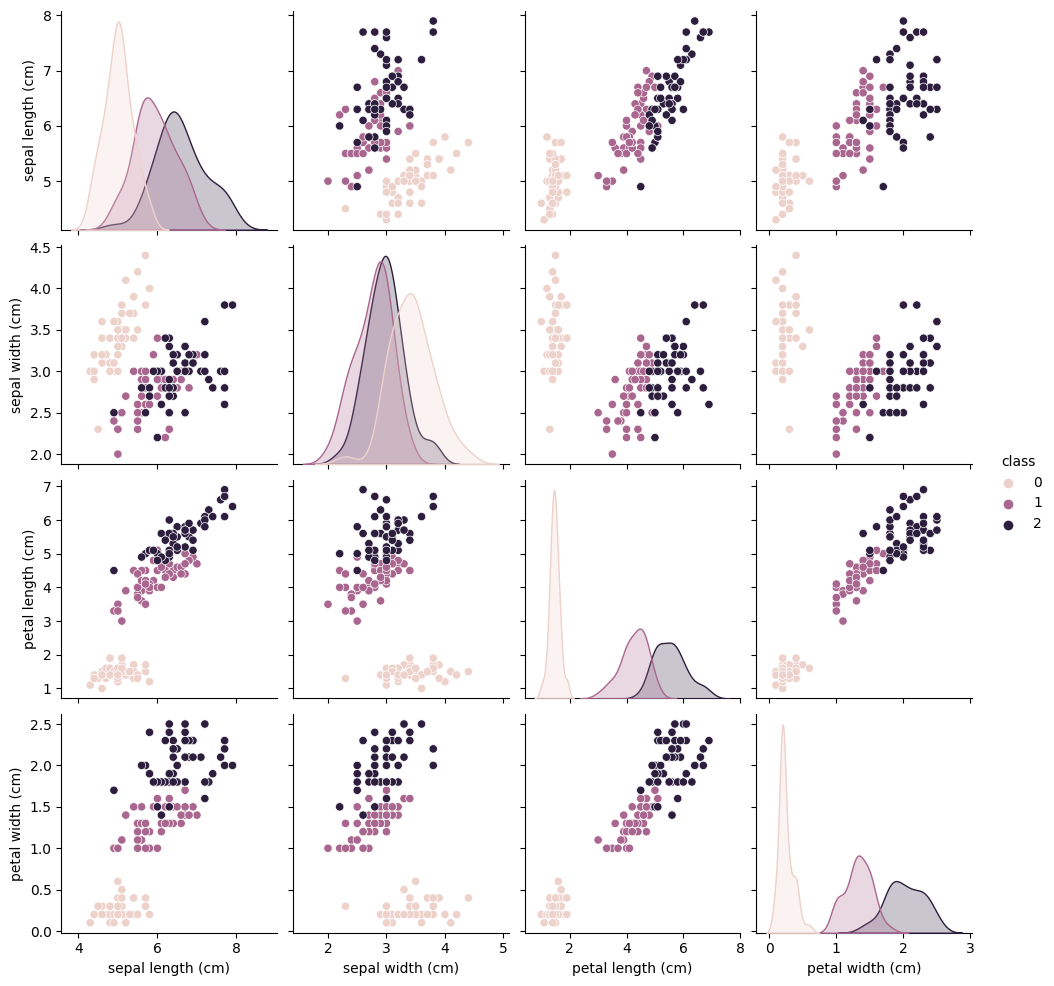

In [4]:
g = sns.pairplot(iris_df,hue='class',kind='scatter')

In [5]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


<AxesSubplot: >

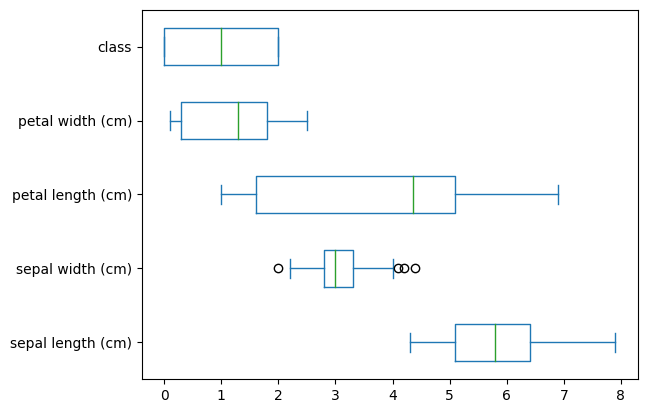

In [6]:
iris_df.plot(kind='box', vert=False)

<AxesSubplot: ylabel='Density'>

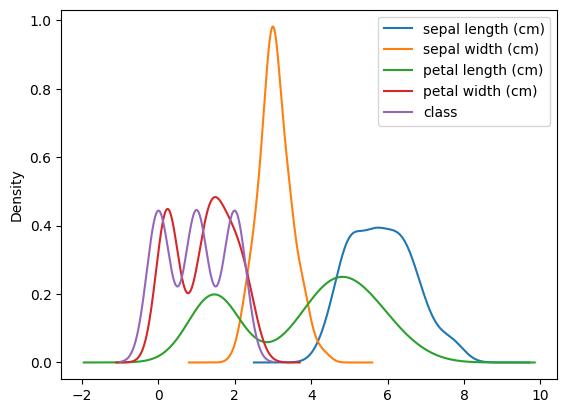

In [7]:
iris_df.plot(kind='kde')

In [40]:
y=iris_df['class']
X=iris_df.drop('class',axis=1)
features_num=['sepal length (cm)', 'petal length (cm)',
       'petal width (cm)']
features_num_out=['sepal width (cm)']
X=X[features_num_out+features_num]
X_train,X_test,y_train,y_test= train_test_split(X,y, train_size=0.8,random_state=12)

In [41]:
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
class NumericalIQscaler(BaseEstimator,TransformerMixin):
    def __init__(self, columns):
        self.columns=columns
        self._scaler = RobustScaler()
        return None
    
    def fit(self, X,y=None):
      
        X = self._scaler.fit(X)
        return self
    
    def remover_outlier(self, X):
        x= pd.DataFrame(X,columns=self.columns)

        for col in x.columns:
            Q1= x[col].quantile(0.25)
            Q3= x[col].quantile(0.75)
            IQR= Q3-Q1
            low= Q1 -1.5*IQR
            high= Q1+1.5*IQR

            x[col] = np.where(x[col]<low,low,x[col])
            x[col] = np.where(x[col]>high, high,x[col])
        return x
    def transform(self, X):
        #X=> dataframe => X.columns, X.index, X.head(), X.sample() 
        X =self.remover_outlier(X)
        X=pd.DataFrame(self._scaler.transform(X),columns=X.columns,index=X.index)
        return X

In [42]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler


In [43]:
X.columns

Index(['sepal width (cm)', 'sepal length (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [44]:
from sklearn.compose import ColumnTransformer


preprocessor_robust= ColumnTransformer(
    transformers=[
   ('robust', NumericalIQscaler(columns=features_num_out),features_num_out)
    ]
)
preprocessor_columns= ColumnTransformer(
    transformers=[
     ('trans_num', MinMaxScaler(),features_num ),
    ]
)

# transformer_num= Pipeline(steps=[
#     ('robust', NumericalIQscaler(columns=['sepal width (cm)'])),
#     ('preprocessor_columns',preprocessor_columns)
#     ])
# # numerical_transformer= Pipeline (steps=[
# # ('scaler', StandardScaler())
# # ])

from sklearn.pipeline import FeatureUnion
preprocessorunion = FeatureUnion(
transformer_list=[
('robust', preprocessor_robust),
('preprocessor_columns',preprocessor_columns)
])

In [45]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(
    steps=[('preprocessors', preprocessorunion),   
            ('modelo_ridge', LogisticRegression()) ])

In [46]:
pipeline

Pipeline(steps=[('preprocessors',
                 FeatureUnion(transformer_list=[('robust',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('preprocessor_columns',
                                                 ColumnTransformer(transformers=[('trans_num',
                                                                                  MinMaxScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('modelo_ridge', LogisticRegression())])

In [47]:
model =pipeline.fit(X_train, y_train)

In [16]:
feautes_otput = model['preprocessors'].named_transformers.robust.transformers[-1][-1]+model['preprocessors'].named_transformers.preprocessor_columns.transformers[-1][-1]

In [17]:
model['preprocessors'].transform(X_test)

array([[ 1.        ,  0.19444444,  0.05084746,  0.08333333],
       [-1.        ,  0.55555556,  0.6779661 ,  0.75      ],
       [ 0.        ,  0.02777778,  0.05084746,  0.04166667],
       [-0.4       ,  0.38888889,  0.52542373,  0.5       ],
       [ 0.4       ,  0.69444444,  0.83050847,  0.91666667],
       [ 0.        ,  0.61111111,  0.76271186,  0.70833333],
       [ 0.8       ,  0.52777778,  0.74576271,  0.91666667],
       [ 0.8       ,  0.22222222,  0.08474576,  0.04166667],
       [ 0.        ,  0.94444444,  0.86440678,  0.91666667],
       [ 0.6       ,  0.22222222,  0.11864407,  0.16666667],
       [ 0.        ,  0.36111111,  0.59322034,  0.58333333],
       [ 1.375     ,  0.30555556,  0.05084746,  0.125     ],
       [ 0.8       ,  0.30555556,  0.08474576,  0.125     ],
       [ 1.375     ,  0.22222222,  0.08474576,  0.125     ],
       [ 0.4       ,  0.75      ,  0.62711864,  0.54166667],
       [ 0.4       ,  0.80555556,  0.84745763,  0.70833333],
       [-1.        ,  0.

In [18]:
X_test

,sepal width (cm),sepal length (cm),petal length (cm),petal width (cm)
40,3.5,5.0,1.3,0.3
146,2.5,6.3,5.0,1.9
38,3.0,4.4,1.3,0.2
99,2.8,5.7,4.1,1.3
143,3.2,6.8,5.9,2.3
116,3.0,6.5,5.5,1.8
148,3.4,6.2,5.4,2.3
39,3.4,5.1,1.5,0.2
135,3.0,7.7,6.1,2.3
23,3.3,5.1,1.7,0.5


In [19]:
model.score(X_test, y_test)

0.9

In [20]:
print ('Logistic Model Coefficient: ', model[-1].coef_)
print ('Logistic Model Intercept: ', model[-1].intercept_)

Logistic Model Coefficient:  [[ 1.41751002 -1.36382885 -2.11710323 -2.19753953]
 [-0.98131576  0.39138882 -0.00715085 -0.61477981]
 [-0.43619426  0.97244003  2.12425408  2.81231934]]
Logistic Model Intercept:  [ 2.17477862  0.75241719 -2.9271958 ]


In [21]:
y_predict = model.predict(X_test)

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [23]:
X_train.columns

Index(['sepal width (cm)', 'sepal length (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

    - High Precision + High Recall: The model doesn't misclassify healthy patients and doesn’t wrongly leave out the cancer patients
    - Low Recall + High Precision :  It doesn’t generate a lot of false positives but misses out on a lot of the real cancer patients. Such models cannot be used for life critical data e.g. cancer detection, terrorist identification, accident prevention etc.
    - High Recall+ Low Precision : The model is able to detect most of the positives well but ends up creating a lot of false alarms. Such models should not be used for cases where false alarms have a huge cost — e.g. flight landing systems, 
     Note that such models can work for life critical situations. It is still better to classify a few healthy patients as cancer patients than vice versa.

In [24]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.88      0.78      0.82         9
           2       0.82      1.00      0.90         9

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.89        30
weighted avg       0.91      0.90      0.90        30



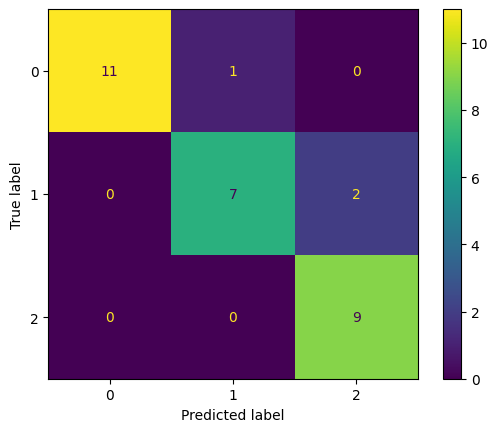

In [25]:
ConfusionMatrixDisplay.from_estimator( model, X_test, y_test)

In [26]:
from sklearn import preprocessing
from sklearn.metrics import RocCurveDisplay
lb = preprocessing.LabelBinarizer()
y_test_label=lb.fit_transform(y_test)
y_predict_label=lb.transform(y_predict)

In [26]:
#y_test, y_test_label


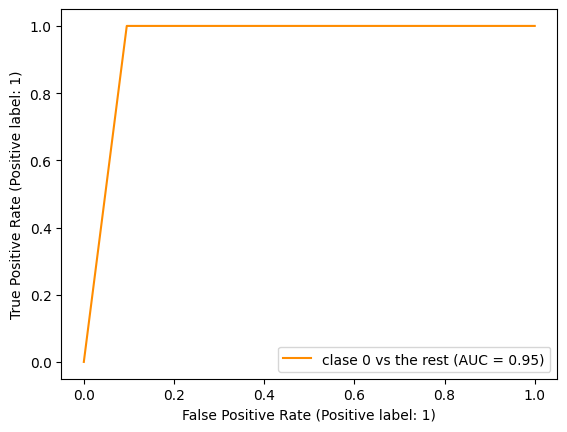

In [27]:
class_id=2
RocCurveDisplay.from_predictions(
    y_test_label[:, class_id],
    y_predict_label[:, class_id],
    name=f"clase 0 vs the rest",
    color="darkorange",
)

In [131]:

from sklearn import tree


In [29]:
from sklearn.linear_model import LogisticRegression
#https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline(
    steps=[('preprocessors', preprocessorunion),   
            ('tree', tree.DecisionTreeClassifier(criterion='entropy')) ])



In [180]:
modeltree= pipeline.fit(X_train,y_train)

In [181]:
modeltree.score(X_test,y_test)

0.9666666666666667

In [182]:
pipeline["tree"]

DecisionTreeClassifier(criterion='entropy')

[Text(0.36363636363636365, 0.9285714285714286, 'petal width (cm) <= 0.292\nentropy = 1.584\nsamples = 120\nvalue = [38, 41, 41]\nclass = versicolor'),
 Text(0.2727272727272727, 0.7857142857142857, 'entropy = 0.0\nsamples = 38\nvalue = [38, 0, 0]\nclass = setosa'),
 Text(0.45454545454545453, 0.7857142857142857, 'petal length (cm) <= 0.653\nentropy = 1.0\nsamples = 82\nvalue = [0, 41, 41]\nclass = versicolor'),
 Text(0.18181818181818182, 0.6428571428571429, 'petal width (cm) <= 0.646\nentropy = 0.281\nsamples = 41\nvalue = [0, 39, 2]\nclass = versicolor'),
 Text(0.09090909090909091, 0.5, 'entropy = 0.0\nsamples = 38\nvalue = [0, 38, 0]\nclass = versicolor'),
 Text(0.2727272727272727, 0.5, 'sepal width (cm) <= 0.2\nentropy = 0.918\nsamples = 3\nvalue = [0, 1, 2]\nclass = virginica'),
 Text(0.18181818181818182, 0.35714285714285715, 'entropy = 0.0\nsamples = 2\nvalue = [0, 0, 2]\nclass = virginica'),
 Text(0.36363636363636365, 0.35714285714285715, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1,

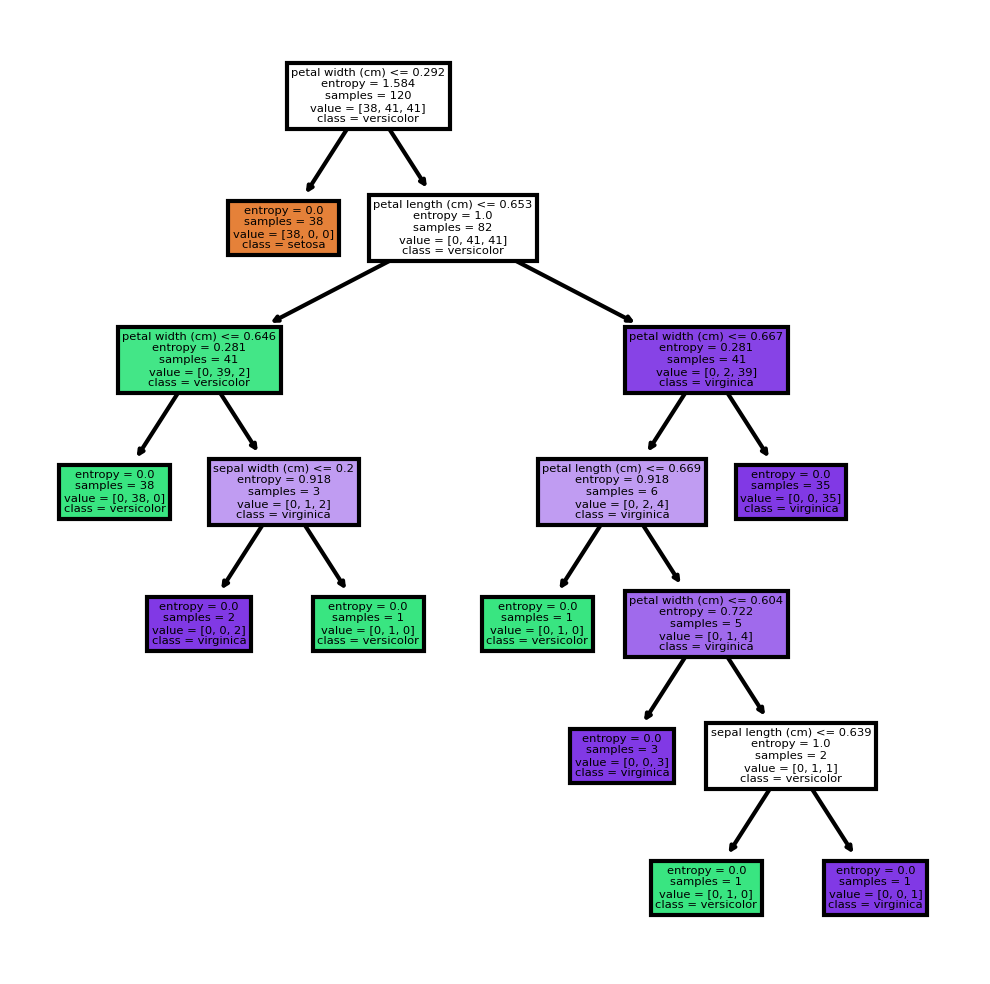

In [183]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 300)
fn = features_num_out+features_num
cn = ['setosa', 'versicolor', 'virginica']
tree.plot_tree(pipeline["tree"], feature_names = fn, 
               class_names=cn,
               filled = True)
               #The left node is True and the right node is False

In [ ]:
#https://github.com/mmmayo13/scikit-learn-classifiers/blob/master/sklearn-classifiers-tutorial.ipynb

In [184]:
text_representation = tree.export_text(pipeline["tree"])
print(text_representation)

|--- feature_3 <= 0.29
|   |--- class: 0
|--- feature_3 >  0.29
|   |--- feature_2 <= 0.65
|   |   |--- feature_3 <= 0.65
|   |   |   |--- class: 1
|   |   |--- feature_3 >  0.65
|   |   |   |--- feature_0 <= 0.20
|   |   |   |   |--- class: 2
|   |   |   |--- feature_0 >  0.20
|   |   |   |   |--- class: 1
|   |--- feature_2 >  0.65
|   |   |--- feature_3 <= 0.67
|   |   |   |--- feature_2 <= 0.67
|   |   |   |   |--- class: 1
|   |   |   |--- feature_2 >  0.67
|   |   |   |   |--- feature_3 <= 0.60
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature_3 >  0.60
|   |   |   |   |   |--- feature_1 <= 0.64
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_1 >  0.64
|   |   |   |   |   |   |--- class: 2
|   |   |--- feature_3 >  0.67
|   |   |   |--- class: 2



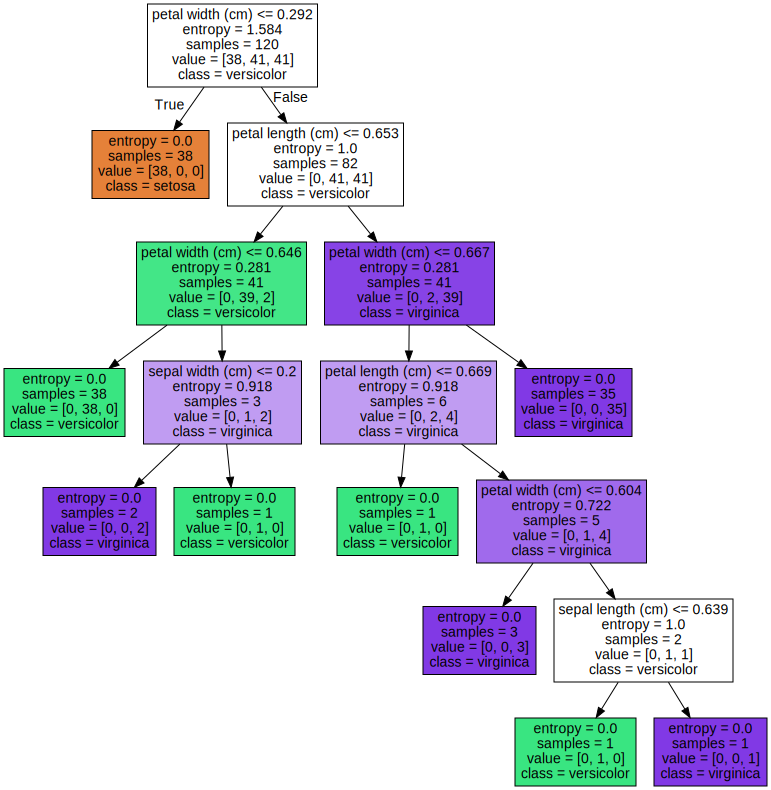

In [186]:
#!pip install graphviz
import graphviz
# DOT data
dot_data = tree.export_graphviz(pipeline["tree"], out_file=None, 
                                feature_names=features_num_out+features_num,  
                                class_names=iris.target_names,
                                filled=True)
graph = graphviz.Source(dot_data) 
graph

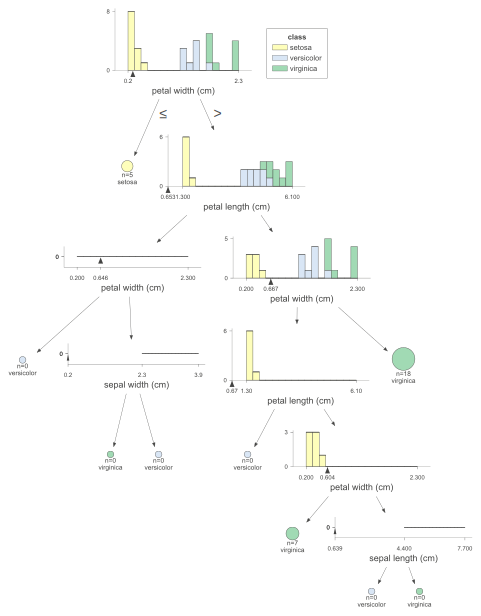

In [205]:
#!pip install dtreeviz
import dtreeviz

viz = dtreeviz.model(pipeline["tree"], X_test, y_test,
                target_name="class",
                feature_names=features_num_out+features_num,
                class_names=list(iris.target_names))

#viz.view(orientation="LR",fancy=True,depth_range_to_display=(1, 2)) #fancy False for complex dtree
viz.view() #fancy False for complex dtree



In [212]:
print(X_test.iloc[1],cn[y_test.iloc[1]])

sepal width (cm)     2.5
sepal length (cm)    6.3
petal length (cm)    5.0
petal width (cm)     1.9
Name: 146, dtype: float64 virginica


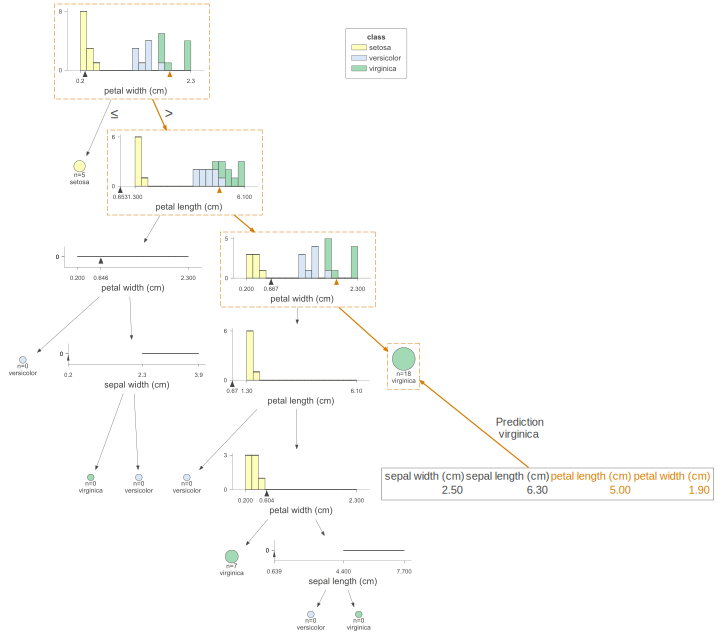

In [211]:


viz.view(x=X_test.iloc[1]) #show_just_path=True



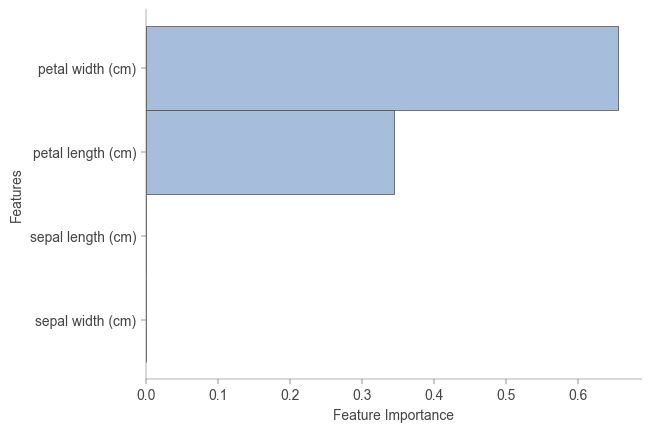

In [189]:
viz.instance_feature_importance(X_test.iloc[0])

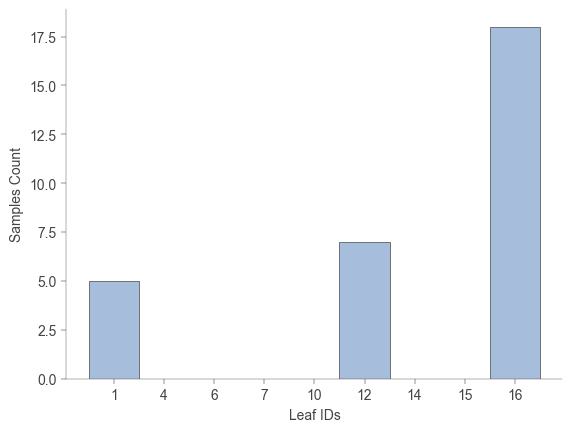

In [190]:
viz.leaf_sizes()

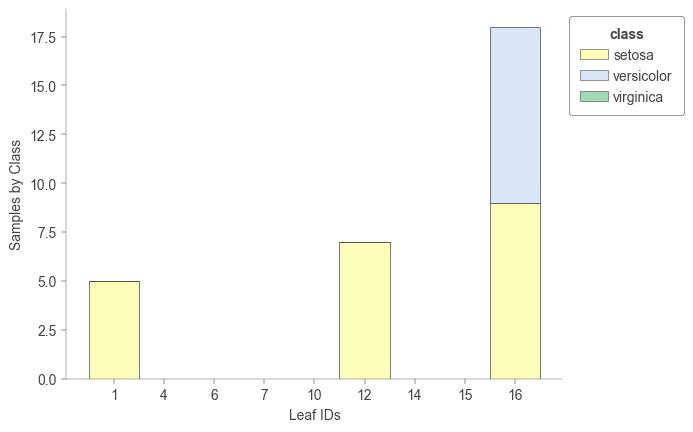

In [191]:
viz.ctree_leaf_distributions()

In [192]:


viz.node_stats(node_id=2)



,sepal width (cm),sepal length (cm),petal length (cm),petal width (cm)
count,25.000000,25.000000,25.00000,25.000000
mean,3.036000,6.008000,4.00000,1.352000
std,0.394631,0.816966,1.73181,0.698284
min,2.300000,4.500000,1.30000,0.300000
25%,2.800000,5.400000,1.70000,0.500000
50%,3.000000,6.100000,4.50000,1.500000
75%,3.300000,6.700000,5.20000,1.800000
max,3.900000,7.700000,6.10000,2.300000


In [213]:
y_predict = modeltree.predict(X_test)

<AxesSubplot: >

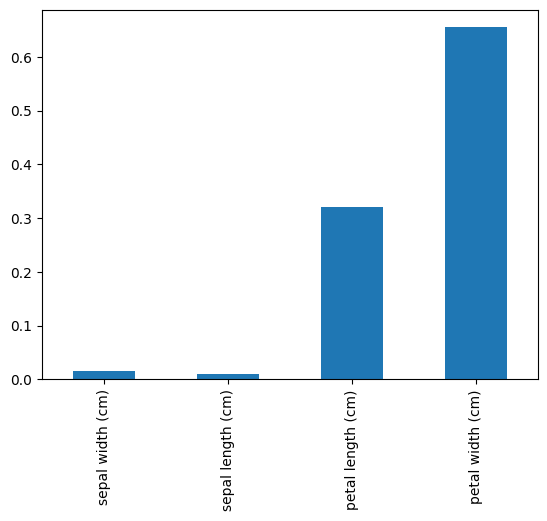

In [214]:
importances = modeltree['tree'].feature_importances_
forest_importances = pd.Series(importances, index=features_num_out+features_num)

fig, ax = plt.subplots()
forest_importances.plot.bar( ax=ax)

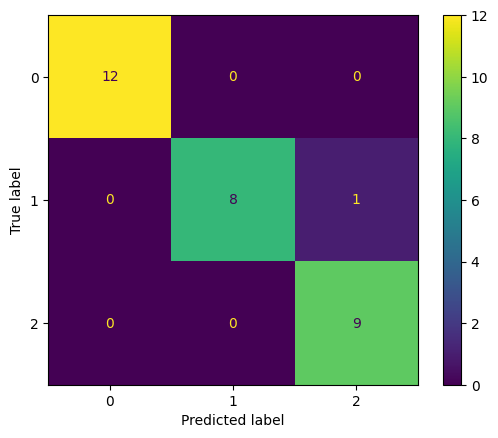

In [215]:
ConfusionMatrixDisplay.from_estimator( modeltree, X_test, y_test)

In [216]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.89      0.94         9
           2       0.90      1.00      0.95         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30



In [217]:
lb = preprocessing.LabelBinarizer()
y_test_label=lb.fit_transform(y_test)
y_predict_label=lb.transform(y_predict)

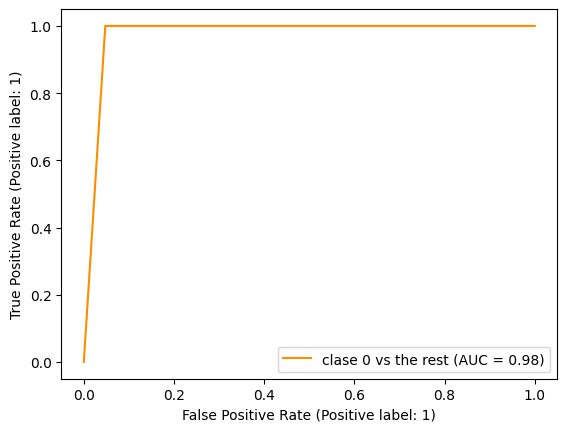

In [218]:
class_id=2
RocCurveDisplay.from_predictions(
    y_test_label[:, class_id],
    y_predict_label[:, class_id],
    name=f"clase 0 vs the rest",
    color="darkorange",
)

In [77]:
from sklearn import svm

# Impot cross-validation functionality
from sklearn.model_selection import cross_val_score

pipeline = Pipeline(
    steps=[('preprocessors', preprocessorunion),   
            ('svm', svm.SVC()) ])

parameters=[
    {
     "svm__C": [0.9,1.1,1.0,0.8],
     "svm__kernel":["linear","poly","rbf"],
    }]

gs_svm = GridSearchCV(estimator= pipeline,param_grid= parameters, scoring= 'accuracy',cv=10)
modelsvm= gs_svm.fit(X_train,y_train)

In [251]:
print(modelsvm.best_params_,modelsvm.best_score_,modelsvm.score(X_test,y_test))

{'svm__C': 1.1, 'svm__kernel': 'poly'} 0.9916666666666666 0.9


In [252]:
y_predict = modelsvm.predict(X_test)

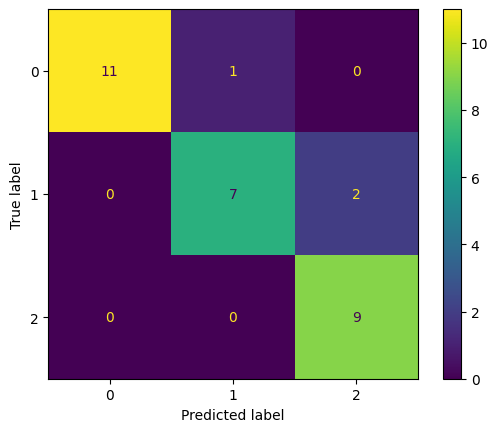

In [253]:
ConfusionMatrixDisplay.from_estimator( modelsvm, X_test, y_test)

In [254]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.88      0.78      0.82         9
           2       0.82      1.00      0.90         9

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.89        30
weighted avg       0.91      0.90      0.90        30



In [91]:
from sklearn.feature_selection import SelectKBest, f_regression
clf = svm.SVC(kernel='linear')
anova_filter = SelectKBest(f_regression, k=1)

In [92]:
anova_svm = make_pipeline(preprocessorunion,anova_filter, clf)
anova_svm.fit(X_train, y_train)


Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('robust',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('preprocessor_columns',
                                                 ColumnTransformer(transformers=[('trans_num',
                                                                                  MinMaxScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('selectkbest',
                 SelectKBest(k=1,
                             score_func=<function f_regression at 0x7fb5c0b1b670>)),
                ('svc', SVC(kernel='linear'))])

In [93]:
_predict = anova_svm.predict(X_test)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.89      0.89      0.89         9
           2       0.90      1.00      0.95         9

    accuracy                           0.93        30
   macro avg       0.93      0.94      0.93        30
weighted avg       0.94      0.93      0.93        30



In [94]:
anova_svm[-2].pvalues_

array([3.76263404e-06, 7.05756802e-24, 1.56415458e-60, 1.53736547e-64])

In [95]:
anova_svm[-2].scores_

array([  23.54911341,  161.90618637, 1047.9720548 , 1245.18102893])

In [231]:
from sklearn.naive_bayes import GaussianNB

# Impot cross-validation functionality
from sklearn.model_selection import cross_val_score


GNB = GaussianNB()

# Evaluate using 10-fold cross-validation
scores = cross_val_score(GNB, X_train, y_train, cv=10)

# Display the individual CV scores
print ('GNB Cross-validation Scores:', scores)

GNB Cross-validation Scores: [1.         0.91666667 0.91666667 0.91666667 1.         1.
 0.91666667 0.91666667 1.         0.83333333]


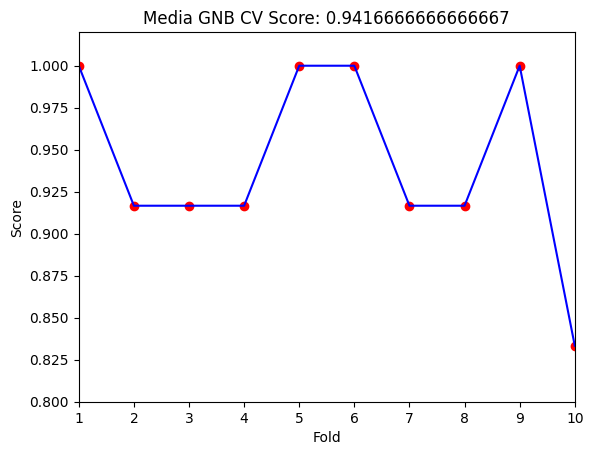

In [232]:
folds = np.array(range(1, 11))

plt.xlabel('Fold')
plt.ylabel('Score')
plt.ylim([0.8,1.02])
plt.xlim([1.0,10.0])

plt.scatter(folds, scores, color='red')
plt.plot(folds, scores, color='blue')
plt.title (f'Media GNB CV Score: {scores.mean()}')
plt.show()

In [48]:


from sklearn.neighbors import KNeighborsClassifier


# Impot cross-validation functionality
from sklearn.model_selection import cross_val_score

pipeline = Pipeline(
    steps=[('preprocessors', preprocessorunion),   
            ('knn', KNeighborsClassifier()) ])

parameters=[
    {
     "knn__n_neighbors": list(range(1,10)),
     "knn__p": list(range(1,4)),

    }]

gs_knn = GridSearchCV(estimator= pipeline,param_grid= parameters, scoring= 'accuracy',cv=10)
model_knn= gs_knn.fit(X_train,y_train)

In [49]:
print(model_knn.best_params_,model_knn.best_score_,model_knn.score(X_test,y_test))

{'knn__n_neighbors': 5, 'knn__p': 2} 0.9666666666666666 0.9333333333333333


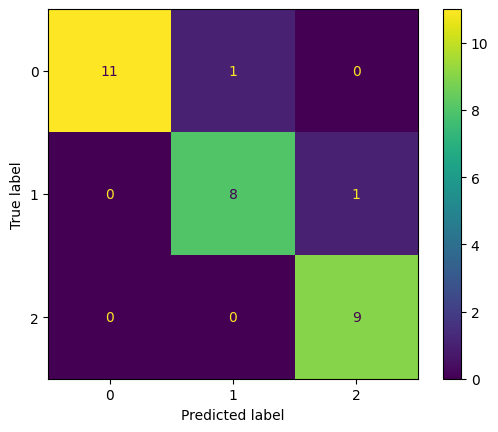

In [50]:
y_predict = model_knn.predict(X_test)
ConfusionMatrixDisplay.from_estimator( model_knn, X_test, y_test)

In [51]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.89      0.89      0.89         9
           2       0.90      1.00      0.95         9

    accuracy                           0.93        30
   macro avg       0.93      0.94      0.93        30
weighted avg       0.94      0.93      0.93        30



In [61]:
#visualizacion knn

In [62]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

In [109]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import RepeatedStratifiedKFold
pipe_KNN = Pipeline([('fselector', SelectKBest()), 
                     ('knn', KNeighborsClassifier())])
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=2, 
                                    random_state=999)

params_pipe_KNN = {'fselector__score_func': [f_classif, mutual_info_classif],
                   'fselector__k': [1, 2, 3, 4],
                   'knn__n_neighbors': [1, 2, 3, 4, 5,6],
                   'knn__p': [1, 2,3]}
 
gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cv_method,
                           scoring='accuracy',
                           verbose=1) 


In [110]:
gs_pipe_KNN.fit(X_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=999),
             estimator=Pipeline(steps=[('fselector', SelectKBest()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'fselector__k': [1, 2, 3, 4],
                         'fselector__score_func': [<function f_classif at 0x7fb5c0b1bf70>,
                                                   <function mutual_info_classif at 0x7fb5c24c7e50>],
                         'knn__n_neighbors': [1, 2, 3, 4, 5, 6],
                         'knn__p': [1, 2, 3]},
             scoring='accuracy', verbose=1)

In [111]:
gs_pipe_KNN.best_estimator_

Pipeline(steps=[('fselector', SelectKBest(k=3)),
                ('knn', KNeighborsClassifier(p=1))])

In [112]:
gs_pipe_KNN.best_params_

{'fselector__k': 3,
 'fselector__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'knn__n_neighbors': 5,
 'knn__p': 1}

In [113]:
gs_pipe_KNN.best_score_

0.9708333333333334

In [114]:


# Impot cross-validation functionality
from sklearn.model_selection import cross_val_score


knn_ = KNeighborsClassifier(n_neighbors=5,p=2)

# Evaluate using 10-fold cross-validation
scoresknn = knn_.fit(X_train.iloc[:,:2], y_train)


(120,)

/home/javier/machine_learning_II_bosque_Jan/env3.10/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length

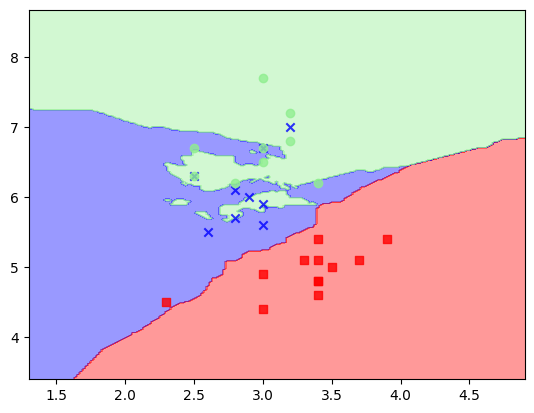

In [65]:
plot_decision_regions(X_test.iloc[:,:2].values, y_test.values, scoresknn)


In [28]:
from sklearn.neural_network import MLPClassifier

In [38]:
pipeline = Pipeline(
    steps=[('preprocessors', preprocessorunion),   
            ('estimador', KNeighborsClassifier(n_neighbors=5,p=2)) ])

params_grid=[

    {
    'estimador':[MLPClassifier(learning_rate='constant')],
        "estimador__hidden_layer_sizes": list(range(10,500,100)) ,
     "estimador__activation":  ["logistic", "tanh", "relu"]

    },
    {'estimador':[MLPClassifier(learning_rate='invscaling')],
        "estimador__hidden_layer_sizes": list(range(10,500,100)) ,
     "estimador__activation":  ["logistic", "tanh", "relu"]},

    {'estimador':[MLPClassifier(learning_rate='adaptive')],
        "estimador__hidden_layer_sizes": list(range(10,500,100)) ,
     "estimador__activation":  ["logistic", "tanh", "relu"]
    }
]

In [39]:
grid = GridSearchCV(pipeline, params_grid,cv=5, scoring='accuracy')

In [40]:
modelmpl= grid.fit(X_train,y_train)

/home/javier/machine_learning_II_bosque_Jan/env3.10/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/javier/machine_learning_II_bosque_Jan/env3.10/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/javier/machine_learning_II_bosque_Jan/env3.10/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/javier/machine_learning_II_bosque_Jan/env3.10/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

In [41]:
modelmpl.best_estimator_

Pipeline(steps=[('preprocessors',
                 FeatureUnion(transformer_list=[('robust',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('preprocessor_columns',
                                                 ColumnTransformer(transformers=[('trans_num',
                                                                                  MinMaxScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('estimador',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=410,
                               learning_rate='invscaling'))])

In [42]:
modelmpl.best_params_

{'estimador': MLPClassifier(activation='tanh', hidden_layer_sizes=410,
               learning_rate='invscaling'),
 'estimador__activation': 'tanh',
 'estimador__hidden_layer_sizes': 410}

In [43]:
modelmpl.best_score_

0.975

In [44]:
modelmpl.score(X_test,y_test)


0.9333333333333333

# Ensambles

In [1]:
#https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data?select=test.tsv.zip
#https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.21423&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

### Intuición del algoritmo Random Forest

##### La intuición del algoritmo de bosque aleatorio se puede dividir en dos etapas.
En la primera etapa, seleccionamos aleatoriamente "k" características de un total de m características y construimos el bosque aleatorio. En la primera etapa, procedemos de la siguiente manera:

- Seleccione aleatoriamente k características de un total de m características donde k < m.
- Entre las características k, calcule el nodo d utilizando el mejor punto de división.
- Divida el nodo en nodos secundarios usando la mejor división.
- Repita de 1 a 3 pasos hasta alcanzar el número de nodos.
- Construya un bosque repitiendo los pasos 1 a 4 n veces para crear n árboles.

En la segunda etapa, hacemos predicciones utilizando el algoritmo de bosque aleatorio entrenado.

- Tomamos las funciones de prueba y usamos las reglas de cada árbol de decisión creado aleatoriamente para predecir el resultado y almacenar el resultado previsto.
- Luego, calculamos los votos para cada objetivo previsto.
- Finalmente, consideramos el objetivo pronosticado más votado como la predicción final del algoritmo de bosque aleatorio.

##### Ventajas y desventajas del algoritmo Random Forest

Las ventajas del algoritmo de bosque aleatorio son las siguientes: 

- El algoritmo de bosque aleatorio se puede utilizar para resolver problemas de clasificación y regresión.
- Se considera un modelo muy preciso y robusto porque utiliza una gran cantidad de árboles de decisión para hacer predicciones.
- Los bosques aleatorios toman el promedio de todas las predicciones hechas por los árboles de decisión, lo que cancela los sesgos. Por lo tanto, no sufre el problema de sobreajuste.
- El clasificador de bosque aleatorio puede manejar los valores faltantes. Hay dos formas de manejar los valores perdidos. El primero es usar valores medianos para reemplazar variables continuas y el segundo es calcular el promedio ponderado por proximidad de los valores faltantes.
- El clasificador de bosque aleatorio se puede utilizar para la selección de características. Significa seleccionar las características más importantes de las características disponibles del conjunto de datos de entrenamiento.

Las desventajas del algoritmo Random Forest se enumeran a continuación: -

- La mayor desventaja de los bosques aleatorios es su complejidad computacional. Los bosques aleatorios son muy lentos para hacer predicciones porque se usa una gran cantidad de árboles de decisión para hacer predicciones. Todos los árboles en el bosque tienen que hacer una predicción para la misma entrada y luego votarla. Por lo tanto, es un proceso que requiere mucho tiempo.
- El modelo es difícil de interpretar en comparación con un árbol de decisiones, donde podemos hacer una predicción fácilmente en comparación con un árbol de decisiones.



In [68]:

from sklearn.ensemble import RandomForestClassifier
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)

rfc_100.fit(X_train, y_train)

y_pred_100 = rfc_100.predict(X_test)
rfc_100.score(X_test,y_test)


0.9666666666666667

In [69]:
feature_scores = pd.Series(rfc_100.feature_importances_, index=X_train.columns).sort_values(ascending=False)


Text(0.5, 1.0, 'Visualizing Important Features')

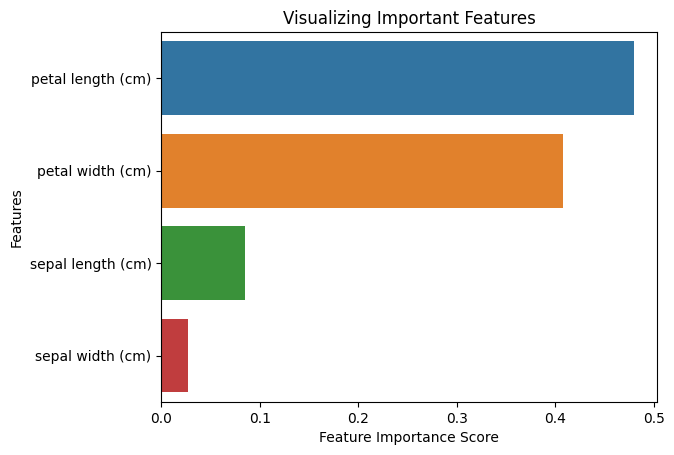

In [70]:
sns.barplot(x=feature_scores, y=feature_scores.index)



# Add labels to the graph

plt.xlabel('Feature Importance Score')

plt.ylabel('Features')



# Add title to the graph

plt.title("Visualizing Important Features")




In [73]:
from sklearn.ensemble import RandomForestClassifier
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)

rfc_100.fit(X_train.iloc[:,2:], y_train)

y_pred_100 = rfc_100.predict(X_test.iloc[:,2:])
rfc_100.score(X_test.iloc[:,2:],y_test)

0.9666666666666667

[Text(0.3333333333333333, 0.9285714285714286, 'petal width (cm) <= 0.8\ngini = 0.666\nsamples = 75\nvalue = [41, 41, 38]\nclass = setosa'),
 Text(0.16666666666666666, 0.7857142857142857, 'gini = 0.0\nsamples = 23\nvalue = [41, 0, 0]\nclass = setosa'),
 Text(0.5, 0.7857142857142857, 'petal width (cm) <= 1.7\ngini = 0.499\nsamples = 52\nvalue = [0, 41, 38]\nclass = versicolor'),
 Text(0.3333333333333333, 0.6428571428571429, 'petal width (cm) <= 1.35\ngini = 0.089\nsamples = 28\nvalue = [0, 41, 2]\nclass = versicolor'),
 Text(0.16666666666666666, 0.5, 'gini = 0.0\nsamples = 16\nvalue = [0, 25, 0]\nclass = versicolor'),
 Text(0.5, 0.5, 'petal length (cm) <= 4.95\ngini = 0.198\nsamples = 12\nvalue = [0, 16, 2]\nclass = versicolor'),
 Text(0.3333333333333333, 0.35714285714285715, 'gini = 0.0\nsamples = 9\nvalue = [0, 15, 0]\nclass = versicolor'),
 Text(0.6666666666666666, 0.35714285714285715, 'petal length (cm) <= 5.35\ngini = 0.444\nsamples = 3\nvalue = [0, 1, 2]\nclass = virginica'),
 Text

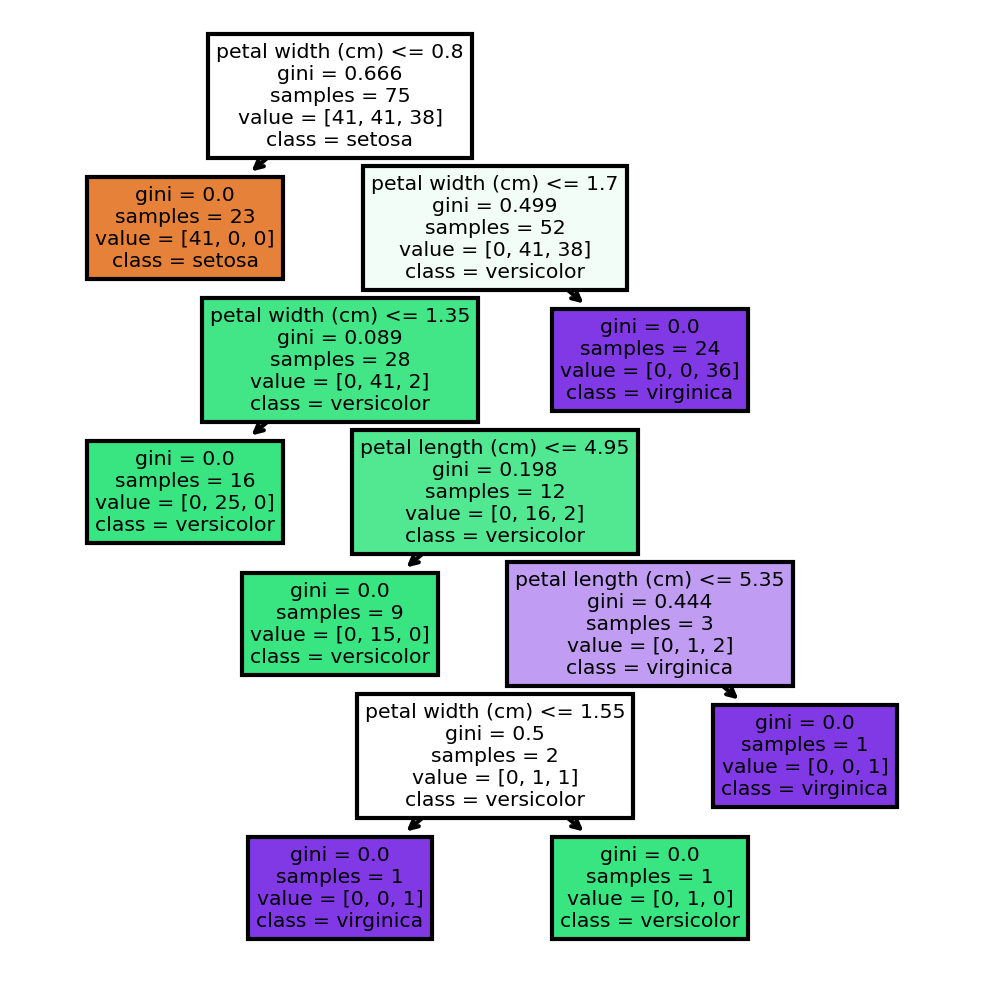

In [75]:
estimator = rfc_100.estimators_[5]
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 300)
fn = features_num[1:]
cn = ['setosa', 'versicolor', 'virginica']
tree.plot_tree(, feature_names = fn, 
               class_names=cn,
               filled = True)

# stack

![image.png](https://machinelearningmastery.com/wp-content/uploads/2020/11/Bagging-Ensemble.png)
![image.png](https://machinelearningmastery.com/wp-content/uploads/2020/11/Stacking-Ensemble.png)

![image.png](https://machinelearningmastery.com/wp-content/uploads/2020/11/Boosting-Ensemble.png)

In [121]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

base_learners = [
                 ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                 ('rf_2', KNeighborsClassifier(n_neighbors=5))             
                ]
clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(),cv=10)
#clf.fit(X_train, y_train)
clf

StackingClassifier(cv=10,
                   estimators=[('rf_1',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('rf_2', KNeighborsClassifier())],
                   final_estimator=LogisticRegression())

In [123]:
modelstack=make_pipeline(preprocessorunion, clf)
modelstack

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('robust',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('preprocessor_columns',
                                                 ColumnTransformer(transformers=[('trans_num',
                                                                                  MinMaxScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('stackingclassifier',
                 StackingClassifier(cv=10,
                                    estimators=[('rf_1',
                                                 RandomForestClassifier(n_estimators=10,
                                                                        random_state=42)),
                                                ('rf_2',
                                                 KNeighborsClassifier())],
                                    final_estimator=LogisticRegression()))])

In [124]:
modelstack.fit(X_train,y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('robust',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('preprocessor_columns',
                                                 ColumnTransformer(transformers=[('trans_num',
                                                                                  MinMaxScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('stackingclassifier',
                 StackingClassifier(cv=10,
                                    estimators=[('rf_1',
                                                 RandomForestClassifier(n_estimators=10,
                                                                        random_state=42)),
                                                ('rf_2',
                                                 KNeighborsClassifier())],
                                    final_estimator=LogisticRegression()))])

In [129]:
trainy_pred_st = modelstack.predict(X_test)

In [130]:
print(classification_report(y_test,trainy_pred_st))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.89      0.89      0.89         9
           2       0.90      1.00      0.95         9

    accuracy                           0.93        30
   macro avg       0.93      0.94      0.93        30
weighted avg       0.94      0.93      0.93        30



In [135]:
layer_one_estimators = [
                        ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                        ('knn_1', KNeighborsClassifier(n_neighbors=5))             
                       ]
layer_two_estimators = [
                        ('dt_2', tree.DecisionTreeClassifier()),
                        ('rf_2', RandomForestClassifier(n_estimators=50, random_state=42)),
                       ]
layer_two = StackingClassifier(estimators=layer_two_estimators, final_estimator=LogisticRegression(),cv=10)
clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two)


In [136]:
modelstack=make_pipeline(preprocessorunion, clf)
modelstack

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('robust',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('preprocessor_columns',
                                                 ColumnTransformer(transformers=[('trans_num',
                                                                                  MinMaxScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('rf_1',
                                                 RandomForestClassifier(n_estimators=10,
                                                                        random_state=42)),
                                                ('knn_1',
                                                 KNeighborsClassifier())],
                                    final_estimator=StackingClassifier(cv=10,
                                                                       estimators=[('dt_2',
                                                                                    DecisionTreeClassifier()),
                                                                                   ('rf_2',
                                                                                    RandomForestClassifier(n_estimators=50,
                                                                                                           random_state=42))],
                                                                       final_estimator=LogisticRegression())))])

In [137]:
modelstack.fit(X_train,y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('robust',
                                                 ColumnTransformer(transformers=[('robust',
                                                                                  NumericalIQscaler(columns=['sepal '
                                                                                                             'width '
                                                                                                             '(cm)']),
                                                                                  ['sepal '
                                                                                   'width '
                                                                                   '(cm)'])])),
                                                ('preprocessor_columns',
                                                 ColumnTransformer(transformers=[('trans_num',
                                                                                  MinMaxScaler(),
                                                                                  ['sepal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'length '
                                                                                   '(cm)',
                                                                                   'petal '
                                                                                   'width '
                                                                                   '(cm)'])]))])),
                ('stackingclassifier',
                 StackingClassifier(estimators=[('rf_1',
                                                 RandomForestClassifier(n_estimators=10,
                                                                        random_state=42)),
                                                ('knn_1',
                                                 KNeighborsClassifier())],
                                    final_estimator=StackingClassifier(cv=10,
                                                                       estimators=[('dt_2',
                                                                                    DecisionTreeClassifier()),
                                                                                   ('rf_2',
                                                                                    RandomForestClassifier(n_estimators=50,
                                                                                                           random_state=42))],
                                                                       final_estimator=LogisticRegression())))])

In [138]:
trainy_pred_st = modelstack.predict(X_test)

In [139]:
print(classification_report(y_test,trainy_pred_st))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.89      0.94         9
           2       0.90      1.00      0.95         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30



# bosting

¿Cómo se lleva a cabo el entrenamiento en el boosting?

El método de entrenamiento varía en función del tipo de proceso de boosting denominado algoritmo de boosting. Sin embargo, un algoritmo sigue los siguientes pasos generales para entrenar el modelo de boosting:
Paso 1

El algoritmo de boosting asigna la misma ponderación a cada muestra de datos. Ingresa los datos al primer modelo de machine learning, llamado algoritmo base. El algoritmo base hace predicciones para cada muestra de datos.
Paso 2

El algoritmo de boosting evalúa las predicciones del modelo y aumenta la ponderación de las muestras que presentan un error más significativo. También asigna una ponderación basada en el rendimiento del modelo. Un modelo que genera excelentes predicciones tendrá una gran influencia sobre la decisión final.
Paso 3

El algoritmo pasa los datos ponderados al siguiente árbol de decisión.
Paso 4

El algoritmo repite los pasos 2 y 3 hasta que las instancias de errores de entrenamiento estén por debajo de cierto límite

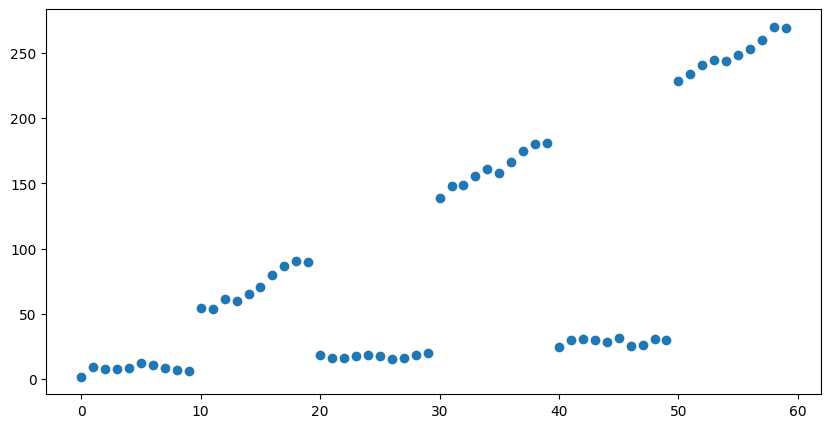

In [145]:
x1 = np.arange(0, 60)
y1 = map(lambda x1: x1 / 2 + (x1 // 10) % 2 * 20 * x1 / 5 + np.random.random() * 10, x1)
df = pd.DataFrame({'x': x1,'y': y1})
X=df[["x"]]
y = df.y

# Plot mock data
plt.figure(figsize=(10, 5))
plt.scatter(X, df.y)
plt.show()

/home/javier/machine_learning_II_bosque_Jan/env3.10/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/javier/machine_learning_II_bosque_Jan/env3.10/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


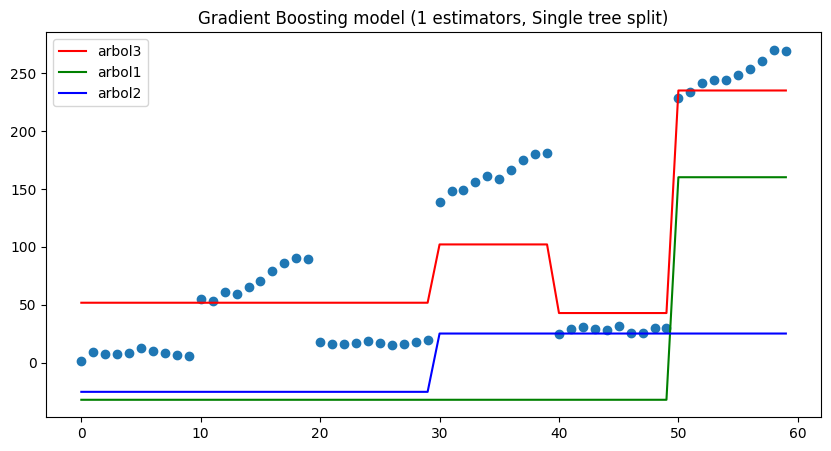

In [169]:
from sklearn import ensemble
params = {
    'n_estimators': 3,
    'max_depth': 1,
    'learning_rate': 1,
    'criterion': 'squared_error'
}

gradient_boosting_regressor = ensemble.GradientBoostingRegressor(**params)

gradient_boosting_regressor.fit(X, y)

plt.figure(figsize=(10, 5))
plt.title('Gradient Boosting model (1 estimators, Single tree split)')
plt.scatter(X, y)
plt.plot(X, gradient_boosting_regressor.predict(X), color='r',label="arbol3")
plt.plot(X, gradient_boosting_regressor.estimators_[0][0].predict(X), color='g',label="arbol1")
plt.plot(X, gradient_boosting_regressor.estimators_[1][0].predict(X), color='b',label="arbol2")
plt.legend()
plt.show()

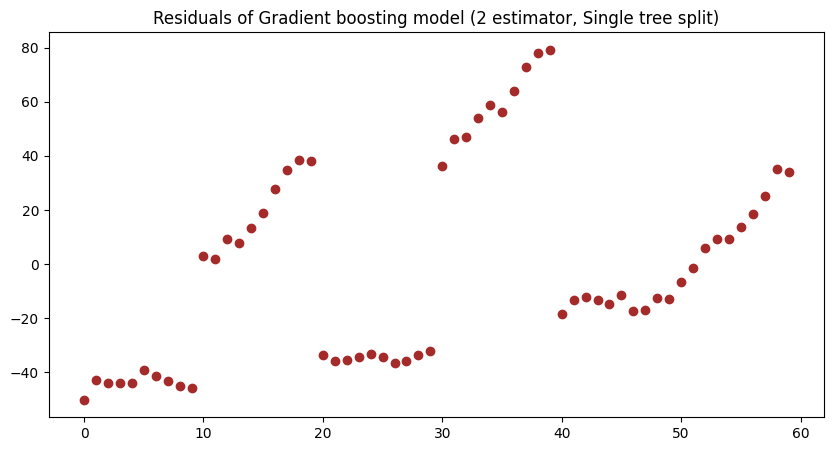

In [170]:
plt.figure(figsize=(10, 5))
plt.title('Residuals of Gradient boosting model (2 estimator, Single tree split)')
plt.scatter(X, y - gradient_boosting_regressor.predict(X), color='brown')
plt.show()

[Text(0.5, 0.75, 'x <= 49.5\nsquared_error = 7873.595\nsamples = 60\nvalue = -0.0'),
 Text(0.25, 0.25, 'squared_error = 3258.164\nsamples = 50\nvalue = -32.029'),
 Text(0.75, 0.25, 'squared_error = 175.839\nsamples = 10\nvalue = 160.143')]

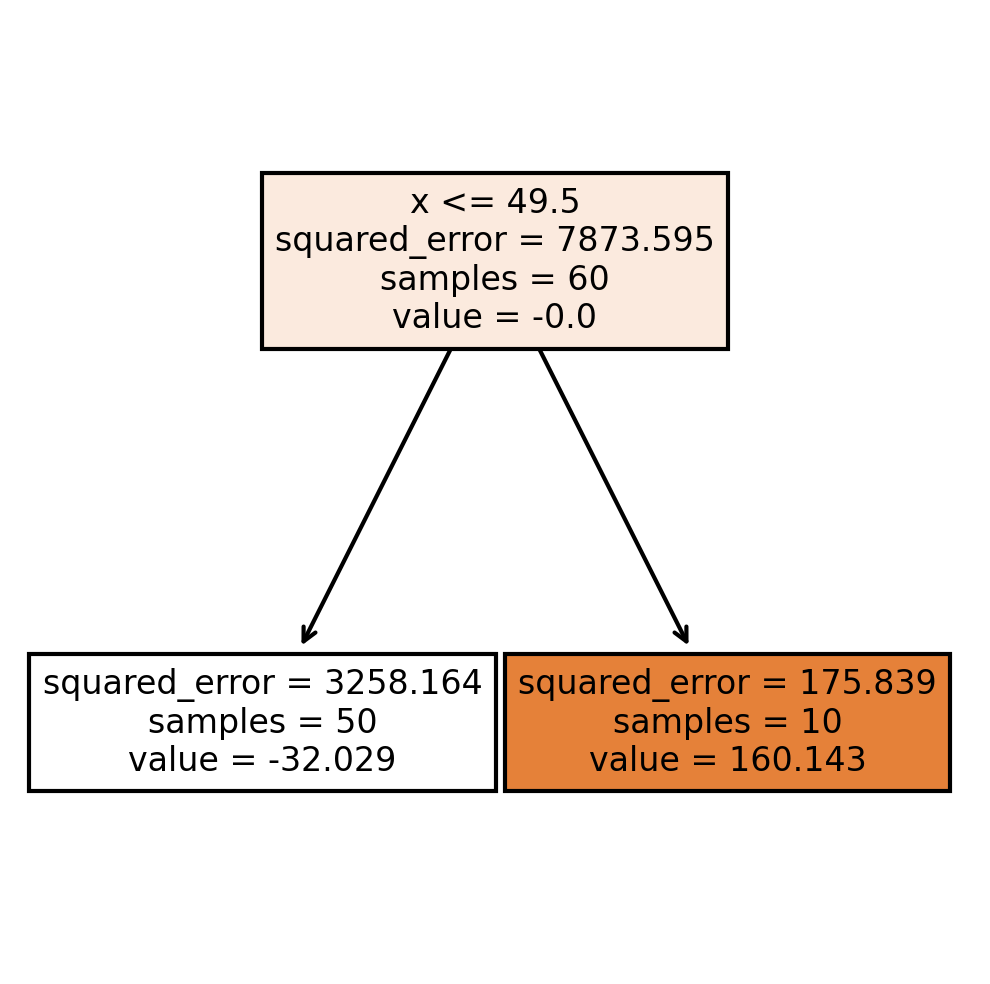

In [164]:
estimator = gradient_boosting_regressor.estimators_[0][0]
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 300)
fn = ["x"]
cn = ["y"]
tree.plot_tree(estimator, feature_names = fn, 
               class_names=cn,
               filled = True)

[Text(0.5, 0.75, 'x <= 29.5\nsquared_error = 2744.443\nsamples = 60\nvalue = 0.0'),
 Text(0.25, 0.25, 'squared_error = 843.125\nsamples = 30\nvalue = -25.172'),
 Text(0.75, 0.25, 'squared_error = 3378.531\nsamples = 30\nvalue = 25.172')]

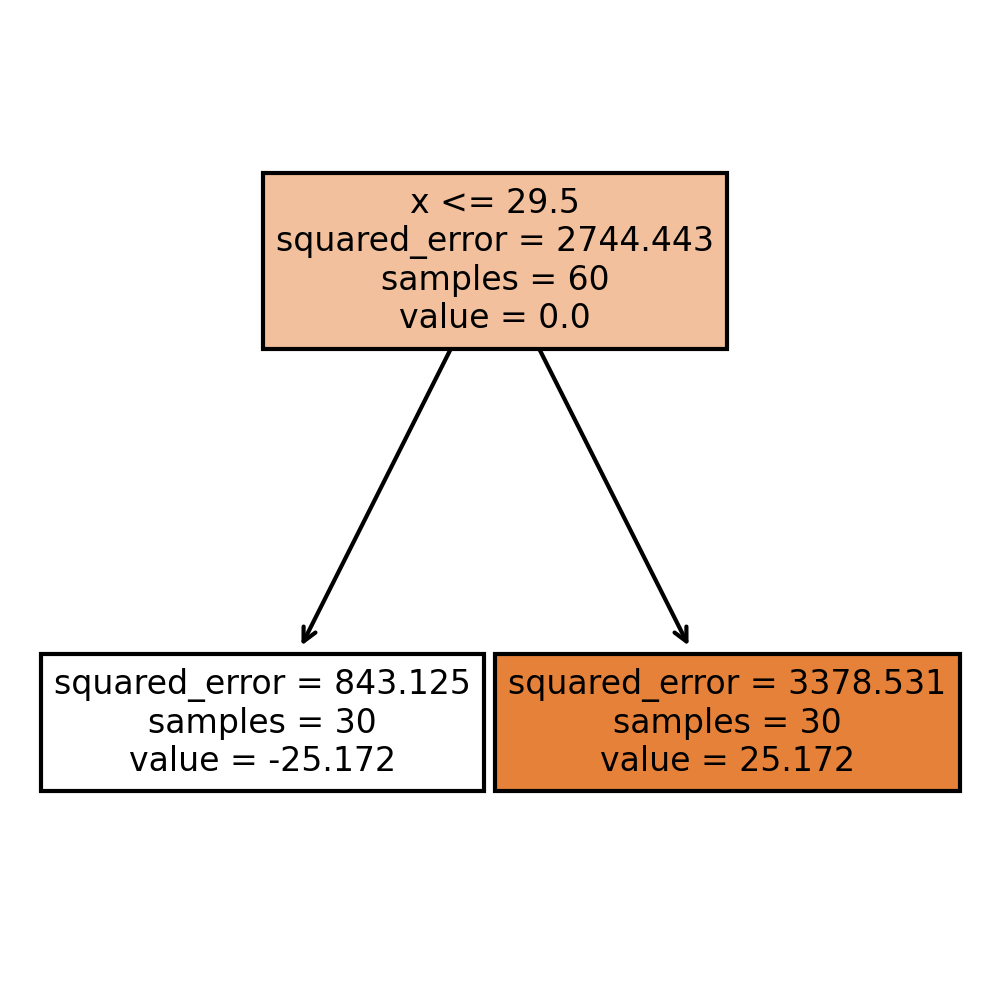

In [166]:
estimator = gradient_boosting_regressor.estimators_[1][0]
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 300)
fn = ["x"]
cn = ["y"]
tree.plot_tree(estimator, feature_names = fn, 
               class_names=cn,
               filled = True)

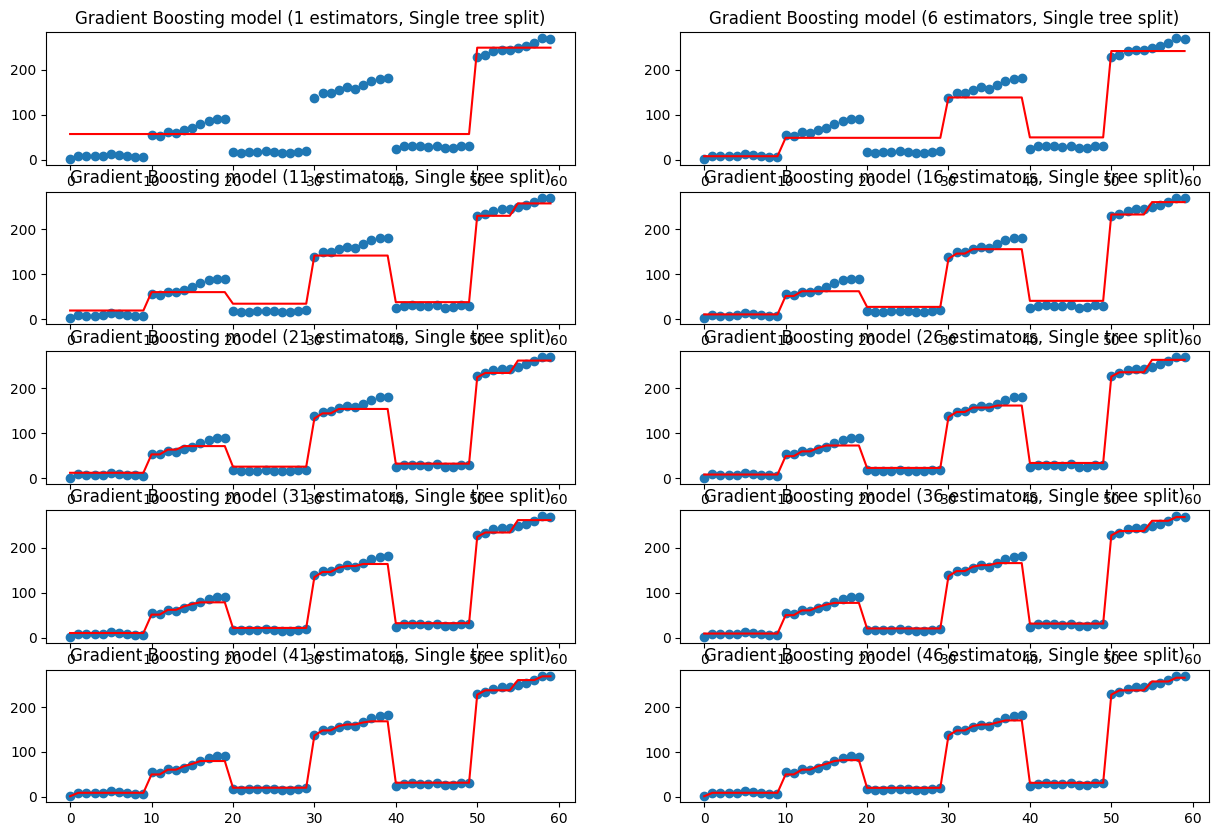

In [176]:
f, ax = plt.subplots(5, 2, figsize=(15, 10))

for idx, n_estimators in enumerate(range(1,50,5)):
    params['n_estimators'] = n_estimators

    gradient_boosting_regressor = ensemble.GradientBoostingRegressor(**params)

    gradient_boosting_regressor.fit(X, y)
    subplot = ax[idx // 2][idx % 2]
    subplot.set_title('Gradient Boosting model ({} estimators, Single tree split)'.format(n_estimators))
    subplot.scatter(X, y)
    subplot.plot(X, gradient_boosting_regressor.predict(X), color='r')
plt.show()

In [178]:
from sklearn.ensemble import AdaBoostClassifier

base_estimator = tree.DecisionTreeClassifier(max_depth=3, random_state=0)
adaboost = AdaBoostClassifier(estimator=base_estimator,
                              n_estimators=3, algorithm="SAMME",
                              random_state=0)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=3,
                                                    random_state=0),
                   n_estimators=3, random_state=0)

In [189]:
#!pip install xgboost
#https://xgboost.readthedocs.io/en
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [188]:
xgb_model.score(X_test,y_test)

0.9666666666666667

In [298]:
from sklearn.model_selection import StratifiedKFold
xgb_model = xgb.XGBClassifier()
#skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)
parameters={"objective":['multi:softprob'],
            "eval_metric":["auc"],
            "max_depth":[5,10,15,20],
            #"early_stopping_rounds":[5],
            "learning_rate": [0.01,0.05,0.001],
            "n_estimators":[100,150]}
GSX=GridSearchCV(estimator=xgb_model,
             param_grid=parameters, cv=3, scoring='accuracy',verbose=1)

In [299]:
#fit_params={"eval_set":[(X_test,y_test)]}
sa=GSX.fit(X_train,y_train, eval_set = [(X_train,y_train),(X_test,y_test)])

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[0]	validation_0-auc:0.97468	validation_1-auc:0.91905
[1]	validation_0-auc:0.97468	validation_1-auc:0.91905
[2]	validation_0-auc:0.97468	validation_1-auc:0.91905
[3]	validation_0-auc:0.97468	validation_1-auc:0.91905
[4]	validation_0-auc:0.97468	validation_1-auc:0.91905
[5]	validation_0-auc:0.97468	validation_1-auc:0.91905
[6]	validation_0-auc:0.97468	validation_1-auc:0.91905
[7]	validation_0-auc:0.97468	validation_1-auc:0.91905
[8]	validation_0-auc:0.97468	validation_1-auc:0.91905
[9]	validation_0-auc:0.97468	validation_1-auc:0.91905
[10]	validation_0-auc:0.97468	validation_1-auc:0.91905
[11]	validation_0-auc:0.97468	validation_1-auc:0.91905
[12]	validation_0-auc:0.97468	validation_1-auc:0.91905
[13]	validation_0-auc:0.97468	validation_1-auc:0.91905
[14]	validation_0-auc:0.97468	validation_1-auc:0.91905
[15]	validation_0-auc:0.97468	validation_1-auc:0.91905
[16]	validation_0-auc:0.97468	validation_1-auc:0.91905
[17]	validatio

In [300]:

sa.best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 100,
 'objective': 'multi:softprob'}

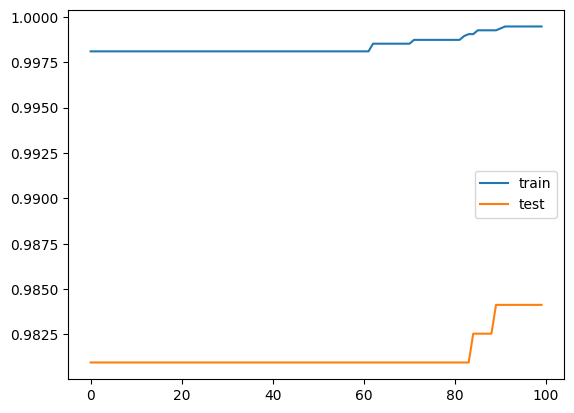

In [301]:
plt.plot(sa.best_estimator_.evals_result()["validation_0"]["auc"],label='train')
plt.plot(sa.best_estimator_.evals_result()["validation_1"]["auc"],label='test')
plt.legend()